In [1]:
import parselmouth
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
snd = parselmouth.Sound("d:/Langon/reform/legvid/劉櫂豪-127903.mp3")

In [3]:
snd.values.shape

(2, 30993935)

In [4]:
intensity = snd.to_intensity()
pitch = snd.to_pitch_ac()
formant = snd.to_formant_burg()

In [5]:
pitch = snd.to_pitch_ac(pitch_ceiling=500)
# pitch = pitch.smooth()

In [6]:
t0, t1 = snd.get_start_time(), snd.get_end_time()
delta = 0.01
ts = np.arange(t0, t1, delta)
int_values = [intensity.get_value(t) for t in ts]
pitch_values = [pitch.get_value_at_time(t) for t in ts]
f1_values = [formant.get_value_at_time(1,t) for t in ts]
f2_values = [formant.get_value_at_time(2,t) for t in ts]
f3_values = [formant.get_value_at_time(3,t) for t in ts]

In [7]:
pitch.get_value_at_time(58.866450)

318.67323664499037

(50.0, 100.0)

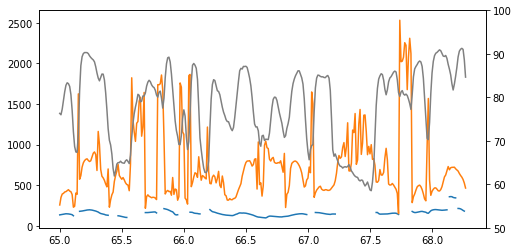

In [16]:
s, o = 6500,6828
plt.figure(figsize=(8,4))
plt.plot(ts[s:o], pitch_values[s:o])
plt.plot(ts[s:o], f1_values[s:o])
ax2 = plt.gca().twinx()
ax2.plot(ts[s:o], int_values[s:o], color='gray')
ax2.set_ylim(50,100)


## Pause detection

In [85]:
int_vec = np.array(int_values)
int_vec[np.isnan(int_vec)] = 0

(array([1.000e+00, 6.800e+01, 1.232e+03, 4.189e+03, 3.515e+03, 2.247e+03,
        1.851e+03, 1.726e+03, 1.998e+03, 2.414e+03, 2.886e+03, 3.472e+03,
        4.088e+03, 4.796e+03, 5.611e+03, 5.824e+03, 6.038e+03, 5.686e+03,
        4.842e+03, 2.072e+03]),
 array([50.3896448 , 52.50879288, 54.62794096, 56.74708904, 58.86623712,
        60.9853852 , 63.10453328, 65.22368136, 67.34282944, 69.46197751,
        71.58112559, 73.70027367, 75.81942175, 77.93856983, 80.05771791,
        82.17686599, 84.29601407, 86.41516214, 88.53431022, 90.6534583 ,
        92.77260638]),
 <BarContainer object of 20 artists>)

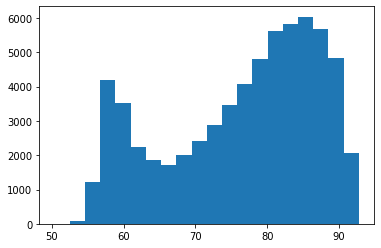

In [86]:
plt.hist(int_vec[int_vec>50], bins=20)

In [87]:
from sklearn.mixture import GaussianMixture

In [88]:
mix = GaussianMixture(2)

In [89]:
mix.fit(int_vec.reshape(-1,1))

GaussianMixture(n_components=2)

In [91]:
mix.means_

array([[63.93504499],
       [82.85661878]])

(50.0, 100.0)

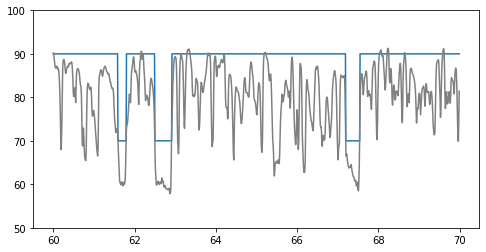

In [111]:
# courtesy to https://stackoverflow.com/questions/24885092/finding-the-consecutive-zeros-in-a-numpy-array
s, o = 6000,7000
thres = 20
plt.figure(figsize=(8,4))
gmm_preds = mix.predict(int_vec.reshape(-1, 1))
is_zero = np.concatenate(([0], (gmm_preds==0).view(np.int8), [0]))
absdiff = np.abs(np.diff(is_zero))
zero_ranges = np.where(absdiff==1)[0].reshape(-1, 2)
pauses = []
for i in range(zero_ranges.shape[0]):
    zp = zero_ranges[i, :]
    if zp[1]-zp[0] < thres:
        gmm_preds[zp[0]:zp[1]] = 1
    else:
        pauses.append((ts[zp[0]], ts[zp[1]]))
# plt.plot(int_vec_ts[s:o], is_silence[s:o])
plt.plot(ts[s:o], gmm_preds[s:o]*20+70)
plt.plot(ts[s:o], int_vec[s:o], color='gray')
plt.gca().set_ylim(50,100)

In [116]:
[p for p in pauses if p[1]-p[0]>1]

[(0.0, 9.620000000000001),
 (15.780000000000001, 21.02),
 (94.23, 95.28),
 (301.97, 303.46),
 (351.66, 353.41),
 (460.0, 461.09000000000003),
 (513.88, 515.1),
 (643.58, 644.89)]